In [31]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import scipy.misc


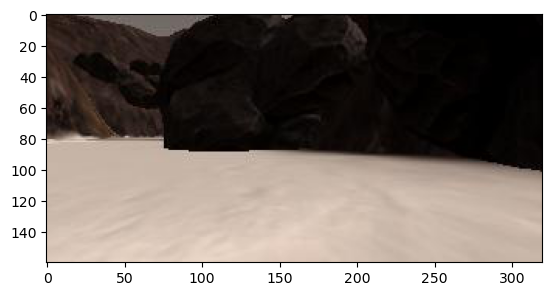

In [32]:
path = "../data/IMG/*"
img_list = glob.glob(path)
idx = np.random.randint(0,len(img_list)-1)
grid_img  = mpimg.imread(img_list[idx])
plt.imshow(grid_img )

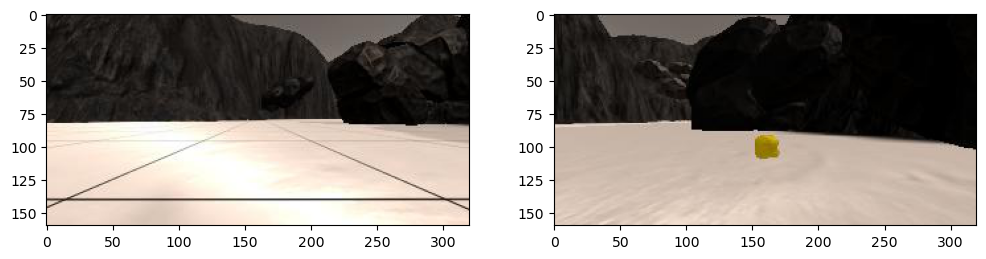

In [3]:
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"

grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

# *Perspective Transform*

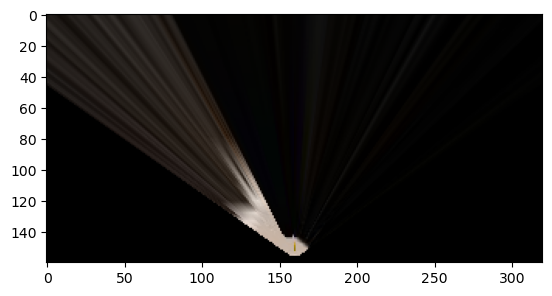

In [15]:
def perspect_transform(img,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img,M,(img.shape[1], img.shape[0]))
    return warped


    dst_size = 5
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[rock_img.shape[1]/2 - dst_size, rock_img.shape[0] - bottom_offset],
                     [rock_img.shape[1]/2 + dst_size,rock_img.shape[0] - bottom_offset],
                     [rock_img.shape[1]/2 + dst_size,rock_img.shape[0] -2*dst_size- bottom_offset],
                     [rock_img.shape[1]/2 - dst_size,rock_img.shape[0] -2*dst_size- bottom_offset]])

warped = perspect_transform(rock_img,source,destination)     
plt.imshow(warped)                
    

# *Thresholding*


In [ ]:

def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 255
    # Return the binary image
    return color_select


threshold = color_thresh(warped)
plt.imshow(threshold,cmap="gray")


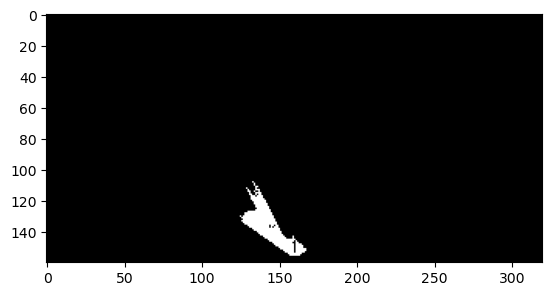

In [19]:
def obstacle_thresh(img, obs_thresh=(100, 100, 100)):
  # Finding obstacles
    # Create an array of zeros with the same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be below all three threshold values in rbg_thresh.
    #   Values below the threshold will now contain a boolean array with TRUE.
    below_thresh = ((img[:,:,0] < obs_thresh[0]) &
                    (img[:,:,1] < obs_thresh[1]) &
                    (img[:,:,2] < obs_thresh[2]))
    # Index the array of zeros with the boolean array and set to 1
    color_select[below_thresh] = 255
    return color_select
  
    #scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)
    threshold = obstacle_thresh(warped)
plt.imshow(threshold,cmap="gray")


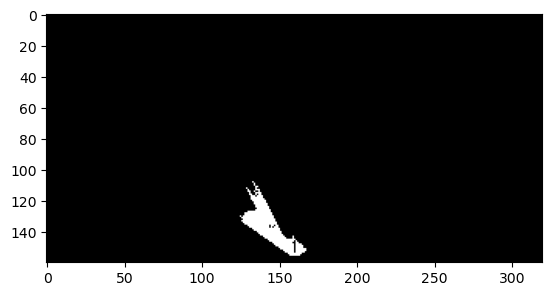

In [20]:
def rock_thresh(img):
  #Finding yellow rock samples
    color_rock = np.zeros_like(img[:,:,0])
    yellow_lower_thresh=(20, 100, 100)
    yellow_upper_thresh=(50, 255, 255)
    rock=(img[:,:,0] < yellow_upper_thresh[0]) \
      & (img[:,:,1] < yellow_upper_thresh[1]) \
      & (img[:,:,2] > yellow_upper_thresh[2]) \
      & (img[:,:,0] > yellow_lower_thresh[0]) \
      & (img[:,:,1] > yellow_lower_thresh[1]) \
      & (img[:,:,2] < yellow_lower_thresh[2])
      
    color_rock[rock]=255
    return color_rock
    threshold = rock_thresh(warped)
plt.imshow(threshold,cmap="gray")


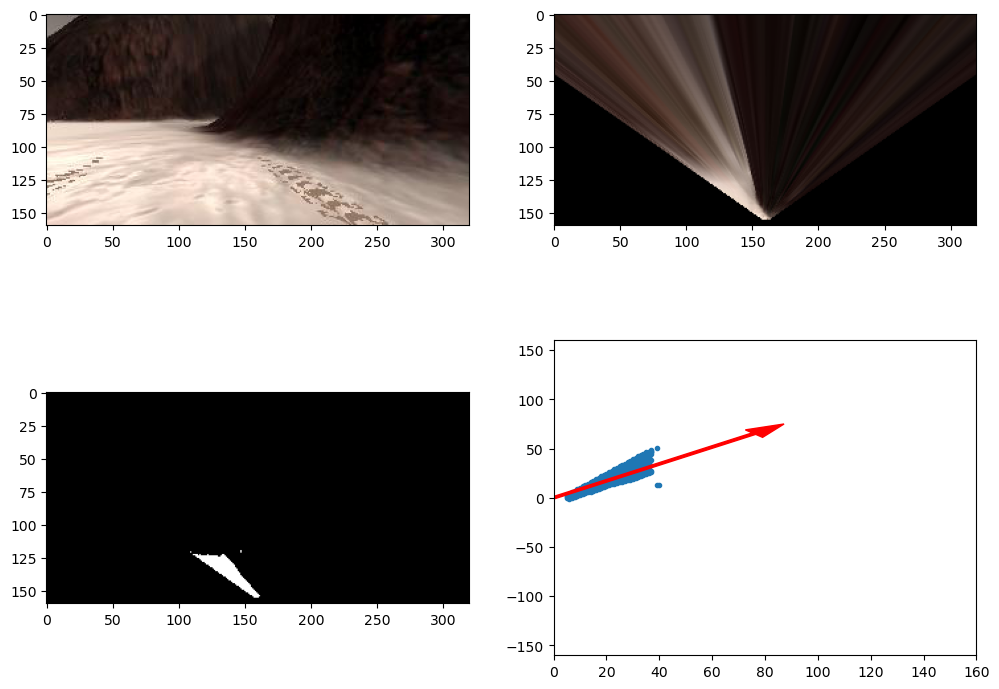

In [22]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel*2 + y_pixel*2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


#grab another random image
index = np.random.randint(0,len(img_list)-1)
image = mpimg.imread(img_list[index])
warped = perspect_transform(image,source,destination)
threshold = color_thresh(warped)

#calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix,ypix = rover_coords(threshold)
dist,angles = to_polar_coords(xpix,ypix)
mean_dir = np.mean(angles)

#do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshold,cmap="gray")
plt.subplot(224)
plt.plot(xpix,ypix,'.')
plt.ylim(-160,160)
plt.xlim(0,160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0,0,x_arrow,y_arrow,color='red',zorder=2,head_width=10,width=2)



In [28]:
def perception_step(Rover):
    # Perform perception steps to update Rover()
    # TODO: 
    # NOTE: camera image is coming to you in Rover.img
    img = rock.img
    # 1) Define source and destination points for perspective transform
     # Define calibration box in source (actual) and destination (desired) coordinates
        # These source and destination points are defined to warp the image
        # to a grid where each 10x10 pixel square represents 1 square meter
        # The destination box will be 2*dst_size on each side
    dst_size = 5
        # Set a bottom offset to account for the fact that the bottom of the image
        # is not the position of the rover but a bit in front of it
        # this is just a rough guess, feel free to change it!
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                  [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                  ])
            
            
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)      
       
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable = color_thresh(warped)
    rock_samples = rock_thresh(warped)
    obstacles = obstacle_thresh(warped)
    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        #          Rover.vision_image[:,:,1] = rock_sample color-thresholded binary image
        #          Rover.vision_image[:,:,2] = navigable terrain color-thresholded binary image
 
    Rover.vision_image[:,:,0] = obstacles[:,:] 
    Rover.vision_image[:,:,1] = rock_samples[:,:]
    Rover.vision_image[:,:,2] = navigable[:,:]
 


    # 5) Convert map image pixel values to rover-centric coords
    xpix_navigable, ypix_navigable = rover_coords(navigable)
    xpix_obstacles, ypix_obstacles = rover_coords(obstacles)
    xpix_rocks, ypix_rocks = rover_coords(rock_samples)

    # 6) Convert rover-centric pixel values to world coordinates
    scale = 10.0
    xpix_navigable, ypix_navigable = impose_range(xpix_navigable, ypix_navigable)
    xpix_obstacles, ypix_obstacles = impose_range(xpix_obstacles, ypix_obstacles)
    navigable_x_world, navigable_y_world = pix_to_world(xpix_navigable, ypix_navigable,
                                                        Rover.pos[0], Rover.pos[1],
                                                        Rover.yaw, Rover.worldmap.shape[0], scale)
    obstacle_x_world, obstacle_y_world = pix_to_world(xpix_obstacles, ypix_obstacles,
                                                      Rover.pos[0], Rover.pos[1],
                                                      Rover.yaw, Rover.worldmap.shape[0], scale)
    rock_x_world, rock_y_world = pix_to_world(xpix_rocks, ypix_rocks,
                                              Rover.pos[0], Rover.pos[1],
                                              Rover.yaw, Rover.worldmap.shape[0], scale)

    # 7) Update Rover worldmap (to be displayed on right side of screen)
        # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1

        # Only update map if pitch an roll are near zero
    if (Rover.pitch < 1 or Rover.pitch > 359) and (Rover.roll < 1 or Rover.roll > 359):
        # increment = 10
        Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] = 255
        Rover.worldmap[rock_y_world, rock_x_world,1] = 255
        Rover.worldmap[navigable_y_world, navigable_x_world, 2] = 255
            # remove overlap mesurements
        nav_pix = Rover.worldmap[:, :, 2] > 0
        Rover.worldmap[nav_pix, 0] = 0
            # clip to avoid overflow
        Rover.worldmap = np.clip(Rover.worldmap, 0, 255)

    # 8) Convert rover-centric pixel positions to polar coordinates
    # Update Rover pixel distances and angles
        # Rover.nav_dists = rover_centric_pixel_distances
        # Rover.nav_angles = rover_centric_angles

    dist, angles = to_polar_coords(xpix_navigable, ypix_navigable)
    Rover.nav_dists = dist
    Rover.nav_angles = angles
        # Same for rock samples
    dist, angles = to_polar_coords(xpix_rocks, ypix_rocks)
    Rover.samples_dists = dist
    Rover.samples_angles = angles
    return Rover
